# 马尔可夫链蒙特卡洛（Markov Chain Monte Carlo）

MCMC的主要想法就是通过马尔可夫链的方式来从目标分布 $\pi$ 中采样，然后通过采样（蒙特卡洛）的方式来计算目标分布的信息。

如，直方图，均值，方差，最大值等。

之所以这样弄，是因为目标分布通常很难用积分计算，并且直接从目标分布采样也很困难。

如果想要从目标分布进行采样，然后通过蒙特卡洛的方式对目标分布进行分析，就可以使用以下两种办法：

1) **接受拒绝采样（accept - reject sampling）**

    拒绝采样通过构造一个可以把目标分布p(x)包起来的Mq(x)来实现，其中M是一个常数。 q(x)为提议分布（proposal distribution）

    该方法每次的采样点是独立的，可以并行处理。
    
    然而，这个方法一方面是效率的问题，另一个问题是q(x)不容易寻找。

    这个方法，我们会在另一个文件中仔细讨论。

2) **MCMC**

    MCMC通过马尔可夫链的方式采样，当传递次数足够多的时候，得到的分布可能是一个稳态分布 $\pi$, 
    
    MCMC就是通过构建满足目标分布为稳态分布的马尔可夫链来实现对目标分布的采样。
    
    因此，采样后期的数据点就是来自于稳态分布，而前期的数据点知识收敛的过程，需要舍弃，这也就是MCMC中，我们所做的burn in的过程。

    **MCMC与拒绝采样的对比**

    **马尔可夫链蒙特卡洛法**比**拒绝采样法**更容易实现，因为只需要定义马尔可夫链，而不需要定义提议分布（proposal distribution）。

    一般来说马尔可夫链蒙特卡洛法比拒绝采样效率更高，没有大量被拒绝的样本。

    


## 马尔可夫链

对于马尔可夫链有：
$$
P(x_t | x_{t-1}, x_{t-2}, \dots, x_1) = P(x_t | x_{t-1})
$$

对于马尔可夫链，有一特性，那就是可能存在一个稳态分布 $\pi$ 使得：
$$
\pi(x_{t-1})P(x_t | x_{t-1}) = \pi(x_t)
$$

其中 $\pi(x_{t-1}) = \pi(x_t)$ ，也就是：
$$
\pi P(x_t | x_{t-1}) = \pi
$$

那么，如果把 $\pi$ 看作一个向量，把P看作是一个转移矩阵，那么 $\pi$ 就是 $P(x_t | x_{t-1})$的特征向量，对应的特征值为1

如果我们写成连续的形式，那么平稳分布的连续形式就是：
$$
\pi(x^*) = \int \pi(x)p(x^* | x)dx
$$

其中 $\pi(x^*)$ 表示当前的分布， $\pi(x)$ 表示上一个分布

这个稳态分布的右边看起来就是一个简单的联合概率分布，然后把x积分掉，经过边缘化得到 $x^*$的分布，但是有趣的地方就在于左边，得到的关于 $x^*$ 的分布仍然是 $\pi$, 因此 $\pi$ 是稳态分布。

### 细致平稳条件（detailed balance condition）
平稳分布的转移矩阵实在是不好找。但是存在一个充分条件。那就是：
$$
细致平稳条件 \Longrightarrow 稳态分布
$$

**细致平稳条件**

如果非周期马尔可夫链状态转移矩阵P的概率分布 $\pi(x)$ 对所有的i，j满足:

$$ \pi(x) p(x^* | x) = \pi(x^*) p(x | x^*)$$

则称概率分布 $\pi(x)$ 是状态转移矩阵P的稳态分布（Stationary Distribution）

证明：通过细致平稳条件可以推出稳态分布。

$$
\begin{aligned}
\int \pi(x)p(x^* | x) dx &= \int \pi(x^*) p(x | x^*) dx \\
&= \pi(x^*) \int p(x | x^*) dx \\
&= \pi(x^*)
\end{aligned}
$$

由此证明得到：$\pi(x^*) = \int \pi(x)p(x^* | x)dx$ 因此，如果有细致平稳条件，那么一定可以推出来稳态分布。

因此，MCMC只要构造出细致平稳分布，就可以找到稳态分布。



### 构造细致平稳条件

那么对于目标分布 $\pi$ ，如果我们想要构造细致平稳条件，即为：
$$
\pi(x)\,\, something = \pi(x^*)\,\, another\,\, something
$$

其中，`something`和`another something`是我们构造的两个转移矩阵。

那么如果我们任意给定一个马尔可夫链状态转移矩阵Q（通常是一个点附近采样的分布，比如高斯分布等）

很大概率：
$$
\pi(x)Q(x^* | x) \neq \pi(x^*)Q(x | x^*)
$$

这很合理，因为很难这么巧找到一个合适的Q。因此我们可以看想办法构造出一个我们需要的那个 `something` 

即，我们找到两个 $\alpha$ 使得：

$$
\pi(x)Q(x^* | x)\alpha_{left} = \pi(x^*)Q(x | x^*)\alpha_{right}
$$



### 一种简单的MCMC算法

如果我们这样设置 $\alpha$:
$$
\begin{equation}
\left\{
\begin{aligned}
\alpha_{left} = \pi(x^*)Q(x|x^*) \\
\alpha_{right} = \pi(x)Q(x^*|x)
\end{aligned}
\right.
\end{equation}
$$

带入公式可得：
$$
\pi(x)Q(x^* | x)\pi(x^*)Q(x|x^*) = \pi(x^*)Q(x | x^*)\pi(x)Q(x^*|x)
$$


此时，左右两边一定成立，那么我们也就找到了我们需要的转移矩阵`something`,也就是从 $x$ 到 $x^*$ 的转移方式

即：
$$
something = Q(x^*|x)\pi(x^*)Q(x|x^*)
$$

其中，这个something这可以分成两个部分，首先是 $ Q(x^*|x) $ 表示为从$x$采样得到$x^*$的概率

另一个部分是 $\pi(x^*)Q(x|x^*)$ 就是算法中要控制的概率，通过将其设置为接受的概率就构造成了`something`


由此，可以构造两个步骤来表达这两个概率，两个步骤结合，就是两个概率的相乘。

**算法步骤**

一： 构造采样$x^*$的概率

1) 从条件分布$Q(x | x_{t})$中采样得到$x^*$

二： 构造接受的概率

2) 从[0, 1]均匀分布中采样得到u
    
3) 如果 $ u < \pi(x^*)Q(x_t | x^*)$ 则输出$x^*$，否则输出$x$


**缺陷**

这样的方法在构造第二个概率的时候效率比较低

这是由于 $\pi(x^*)Q(x^* | x_t)$ 的范围不一定在[0, 1]之间，可能会有出现比1大的值，那么这种情况都会被拒绝。

从而采样得到的结果，有很大一部分仍然是$x_t$, 也就是在原地踏步。

### Metroplis Hastings 算法

对于：
$$
\pi(x)Q(x^* | x)\alpha_{left} = \pi(x^*)Q(x | x^*)\alpha_{right}
$$

这个算法设置的 $\alpha$ 如下：

$$
\begin{equation}
\left\{
\begin{aligned}
\alpha_{left} = min(1, \frac{\pi(x^*)Q(x|x^*)}{\pi(x)Q(x^*|x)}) \\[6mm]
\alpha_{right} = min(1, \frac{\pi(x)Q(x^*|x)}{\pi(x^*)Q(x|x^*)})
\end{aligned}
\right.
\end{equation}
$$

这个alpha的设置就很神奇。我们带入即可发现：

$$
\pi(x)Q(x^* | x) \, min(1, \frac{\pi(x^*)Q(x|x^*)}{\pi(x)Q(x^*|x)}) = \pi(x^*)Q(x | x^*) \, min(1, \frac{\pi(x)Q(x^*|x)}{\pi(x^*)Q(x|x^*)})
$$

我们观察公式:

当 $\frac{\pi(x^*)Q(x|x^*)}{\pi(x)Q(x^*|x)} \gt 1$ 时，左边等于右边

当 $\frac{\pi(x^*)Q(x|x^*)}{\pi(x)Q(x^*|x)} \leqq 1$时，左边也是等于右边

所以是细致平稳条件，可以推出来稳态分布就是 $\pi$

**算法步骤**

与上个算法一致，可以构造两个阶段的概率。

一： 构造采样$x^*$的概率

1) 从条件分布$Q(x | x_{t})$中采样得到$x^*$

二： 构造接受的概率

2) 从[0, 1]均匀分布中采样得到u
    
3) 如果 $ u < min(1, \frac{\pi(x^*)Q(x|x^*)}{\pi(x)Q(x^*|x)})$ 则输出$x^*$，否则输出$x$

**优点**

由于， 接受的概率 $min(1, \frac{\pi(x^*)Q(x|x^*)}{\pi(x)Q(x^*|x)})$的最大值为1

因此，不存在值超过1，样本被拒绝的情况。从而增加了采样效率。

原地踏步的情况被很好的改善了。

### Gibbs采样

Gibbs采样与上述两种方法都不同，可以认为Gibbs采样是条件概率来构造Q函数的MCMC采样算法。

Gibbs采样构造的Q就是我们需要找到的`something`转移矩阵。 不需要 $\alpha$ 的修正。

**算法步骤**

从条件概率 $p(x_1|x_2^t, x_3^t, \dots, x_n^t)$ 得到 $x_1^{t+1}$

从条件概率 $p(x_2|x_1^{t+1}, x_3^t, \dots, x_n^t)$ 得到 $x_2^{t+1}$

$\dots$

最后所有的点 $\{ (x_1^{t}, x_2^t, \dots, x_n^t) \}$ 就是符号目标分布 $p(x_1， x_2, x_3, \dots, x_n)$ 的样本



**一些感想**

这样的更新方式和坐标上升法(Coordinate Ascent)很像。

## 使用MCMC计算贝叶斯后验分布

贝叶斯公式：

$$
P(\theta | D) = \frac{P(D | \theta)P(\theta)}{P(D)}
$$

此时，$P(\theta|D)$很难计算，因此，我们希望可以使用MCMC计算。


其中

$p(\theta)$ 表示先验(prior)，可以通过建模给定。

$P(D | \theta)$ 表示似然(likelihood), 根据似然函数和数据给出， 对于m条数据有：

$$
P(D | \theta) = \prod_{i=1}^m P(D_i | \theta)
$$

由于P(D)是一个常数，因此有：
$$
P(D | \theta) \propto p(\theta)P(D | \theta)
$$
也就是：
$$
P(D | \theta) \propto p(\theta)\prod_{i=1}^m P(D_i | \theta)
$$


**特别的，在Metroplis Hastings算法中，由于$\pi$分布上下相除的关系，因此目标分布只需要是$p(\theta)P(D | \theta)$ 即可，而不需要P(D)**

证明如下：
在这个过程我们可以发现P(D)由于是常数，会被消除。

$$
\begin{aligned}
& \quad \quad \frac{\pi(x^*)Q(x|x^*)}{\pi(x)Q(x^*|x)} \\[6mm]
&=\frac{P(\theta^*| D)Q(x|x^*)}{P(\theta | D)Q(x^*|x)} \\[6mm]
&=\frac{\frac{P(D|\theta^*)P(\theta^*)}{P(D)}Q(x|x^*)}{\frac{P(D|\theta)P(\theta)}{P(D)}Q(x^*|x)} \\[6mm]
&=\frac{P(D|\theta^*)P(\theta^*)Q(x|x^*)}{P(D|\theta)P(\theta)Q(x^*|x)}
\end{aligned}
$$

因此，我们在做目标分布的时候，直接不考虑P(D)就可以了，因为结果是一样的。


=================================

至此，我们有了后验的表示形式，有了后验分布的采样方法。

那么就可以使用MCMC了。

我们把 $\pi$ 设置为 $ P(D | \theta) \propto p(\theta)\prod_{i=1}^m P(D_i | \theta)$， 把Q设置为一个正态分布。


**注意事项**

1) 注意，MCMC中，由于前期的采样只是一个收敛的过程，采样的结果并不在稳态分布(也就是我们的目标分布)，因此我们需要丢弃前n个样本，这个过程叫做burn in

2) 为了`数值的稳定性`和`计算效率`，通常在计算的时候我们会使用log的方式，即：

$$
log(P(D | \theta)) \propto log(p(\theta)) + \sum_{i=1}^m log(P(D_i | \theta))
$$

对于拒绝的概率：

如果此时Q函数使用的是高斯函数，那么 $Q(x|x^*)$ 和 $Q(x^*|x)$ 由于这两个高斯函数的sigma相同，并且 $x$ 到 $x^*$ 和 $x^*$ 到 $x$ 的距离相同，因此：

$$Q(x|x^*) = Q(x^*|x)$$

$ min(1, \frac{\pi(x^*)Q(x|x^*)}{\pi(x)Q(x^*|x)})$ 也就变成了

$$
min(1, e^{log(\pi(\theta^*)) - log(\pi(\theta_t))})
$$
也就是：
$$
min(1, exp(log(P(D | \theta^*)) - log(P(D | \theta_t))))
$$


## 使用Metroplis Hastings 计算一个贝叶斯的后验问题

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import random

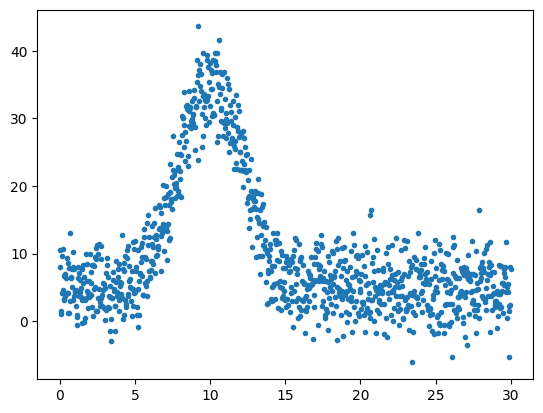

In [2]:
# 模型函数
def my_gauss_func(x, params):
    t1 = params[1] * np.exp(-((x - params[2]) / params[3]) ** 2)
    y = params[0] + t1
    return y


# 模拟数据
n = 1000
er = 0.1
p = [5, 30, 10, 3]  # 真值参数
x = np.linspace(0, 30, n)
y0 = my_gauss_func(x, p)
ey = np.max(y0) * er * np.random.randn(n)
y = y0 + ey
plt.plot(x, y, ".")

In [3]:
# 定义似然函数
def log_likelihood(data_x, data_y, params):
    model_params = params[:-1]
    epsilon = params[-1]
    y_model = my_gauss_func(data_x, model_params)
    return np.sum(norm.logpdf(data_y, loc=y_model, scale=epsilon)) #norm.pdf(x, loc, scale) 计算以y_model为均值，sigma为方差时，出现data_y的概率

# # 定义先验分布（假设先验分布为均值为_prior，方差为10的正态分布）
# def log_prior_prob(params):
#     _prior = [0, 35, 8, 5, 1]
#     res = 0
#     for i in range(5):
#         res += norm.logpdf(params[i], loc=_prior[i], scale=10)
#     return res

# 定义先验分布（假设先验分布为均值为_prior的均匀分布）
def log_prior_prob(params):
    # ture params [5, 30, 10, 3, 0.03]
    _prior = [[0, 10], [0, 50], [0, 30], [0, 10], [0, 10]]
    if all( left < p < right  for p, (left, right) in zip(params, _prior)):
        return 0
    return -np.inf


# 定义后验分布（先验分布 * 似然函数）
#这里没有PD，是因为在Metropolis-Hastings算法中，PD会被消掉
def log_posterior_prob(data_x, data_y, params):
    x =  log_prior_prob(params) + log_likelihood(data_x, data_y, params)
    return x

In [4]:
# Metropolis-Hastings算法

# 设置Q函数为高斯分布，并设置在每个维度的sigma
Q_func_sigma = [0.1, 0.1, 0.1, 0.1, 0.1]


def get_new_point(now_point): # 使用Q函数进行采样
    """
    从条件概率分布Q中抽取样本点x^*
    """
    new_params = np.zeros(5)
    for i in range(5):
        new_params[i] = norm.rvs(loc = now_point[i], scale=Q_func_sigma[i]) # 认为每个Q函数都是高斯分布

    return new_params

def work():

    # 设置采样点的集合
    T = 4000
    samples = np.zeros((T, 5))
    prior = [0, 35, 8, 5, 1]
    start = np.zeros(5)
    for i in range(5):
        start[i] = np.random.normal(prior[i], 0.5)
    samples[0] = start



    for t in range(1, T):
        new_params = get_new_point(samples[t-1]) # 构造采样$x^*$的概率
        alpha = min(1, np.exp(log_posterior_prob(x, y, new_params) - log_posterior_prob(x, y, samples[t-1]))) # 构造接受的概率
        u = random.uniform(0, 1)
        if u < alpha:
            samples[t] = new_params # 接受
        else:
            samples[t] = samples[t-1]  # 拒绝


    # 绘制专业的后验分布
    # 去掉初始的2000个样本，以减少采样初期的影响
    burn_in = 2000
    samples = samples[burn_in: ]

    return samples


n_work = 2
samples = np.vstack([work() for _ in range(n_work)])
samples.shape

/var/folders/jx/hsm21jg10x574b3w9kt9p29w0000gn/T/ipykernel_91552/69364889.py:32: RuntimeWarning: invalid value encountered in double_scalars
  alpha = min(1, np.exp(log_posterior_prob(x, y, new_params) - log_posterior_prob(x, y, samples[t-1]))) # 构造接受的概率
/var/folders/jx/hsm21jg10x574b3w9kt9p29w0000gn/T/ipykernel_91552/69364889.py:32: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(log_posterior_prob(x, y, new_params) - log_posterior_prob(x, y, samples[t-1]))) # 构造接受的概率


(4000, 5)

In [5]:
# 使用seaborn绘制后验分布
df = pd.DataFrame({
    "bias" : samples[:, 0],
    "amplitude" : samples[:, 1],
    "miu": samples[:, 2],
    "sigma" : samples[:, 3],
    "epsilon" : samples[:, 4]
})

[ 5.00253241 30.31010767 10.01676714  2.9344625   3.55184152]
[0.12449943 0.27461835 0.03248512 0.04404497 0.07433038]


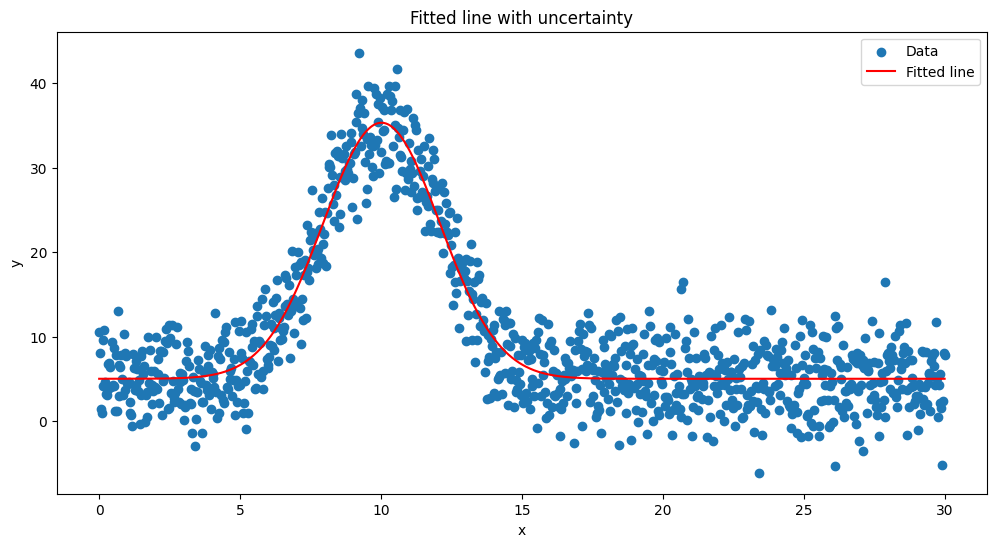

In [6]:
# 绘制拟合的图像
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label='Data')

mean_param = np.mean(samples, axis=0)
std_param = np.std(samples, axis=0)
print(mean_param)
print(std_param)

plt.plot(x, my_gauss_func(x, mean_param), color='red', label='Fitted line')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Fitted line with uncertainty')
plt.show()

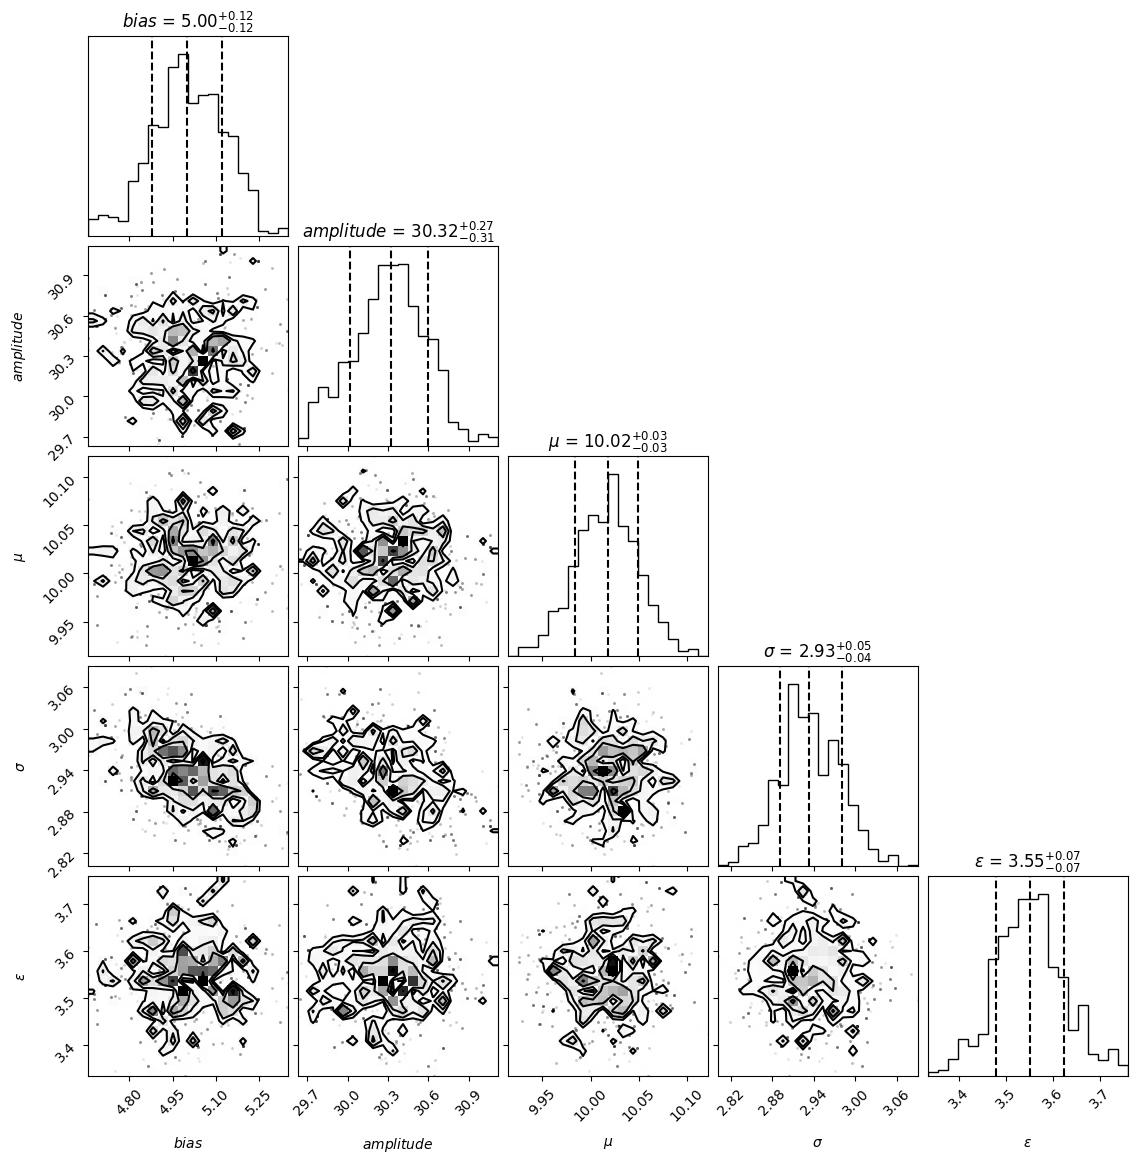

In [7]:
import corner
import matplotlib.pyplot as plt

# 从 DataFrame 提取样本
samples_array = df[["bias", "amplitude", "miu", "sigma", "epsilon"]].values

# 设置标签（与 DataFrame 的列名一致）
labels = ["$bias$", "$amplitude$", "$\mu$", "$\sigma$", "$\epsilon$"]

# 绘制后验分布
fig = corner.corner(samples_array, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})

# 显示图
plt.show()


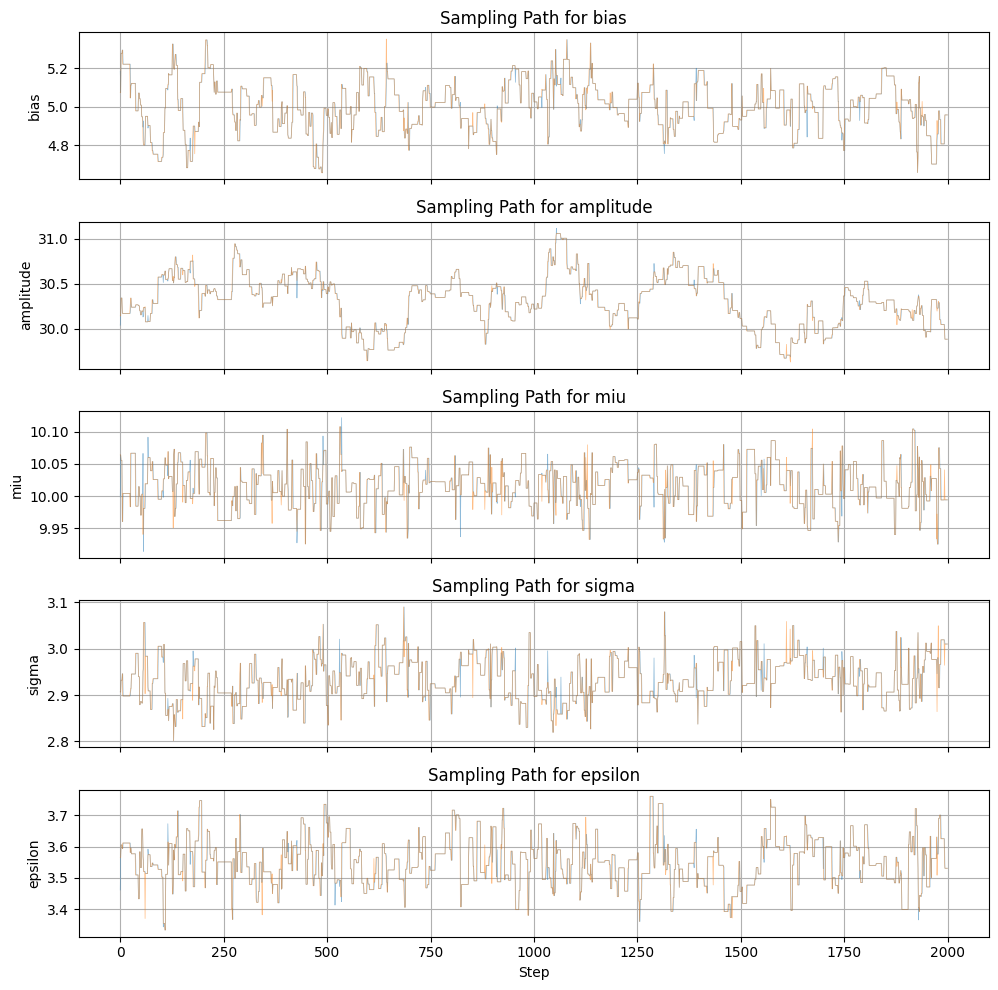

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 假设这些变量已知
ndim = 5  # 参数数量
nsteps = len(samples) // n_work  # 每条链的采样步数

# 重新整理样本为 (nsteps, nwalkers, ndim)
reshaped_samples = samples.reshape((nsteps, n_work, ndim))

# 绘制采样路径
param_names = ["bias", "amplitude", "miu", "sigma", "epsilon"]  # 参数名称
fig, axes = plt.subplots(ndim, 1, figsize=(10, 2 * ndim), sharex=True)

for i in range(ndim):
    ax = axes[i]
    for walker in range(n_work):
        ax.plot(reshaped_samples[:, walker, i], alpha=0.5, lw=0.5)  # 每个 walker 的路径
    ax.set_title(f"Sampling Path for {param_names[i]}")
    ax.set_ylabel(param_names[i])
    ax.grid(True)

axes[-1].set_xlabel("Step")  # 共享 X 轴标签
plt.tight_layout()
plt.show()


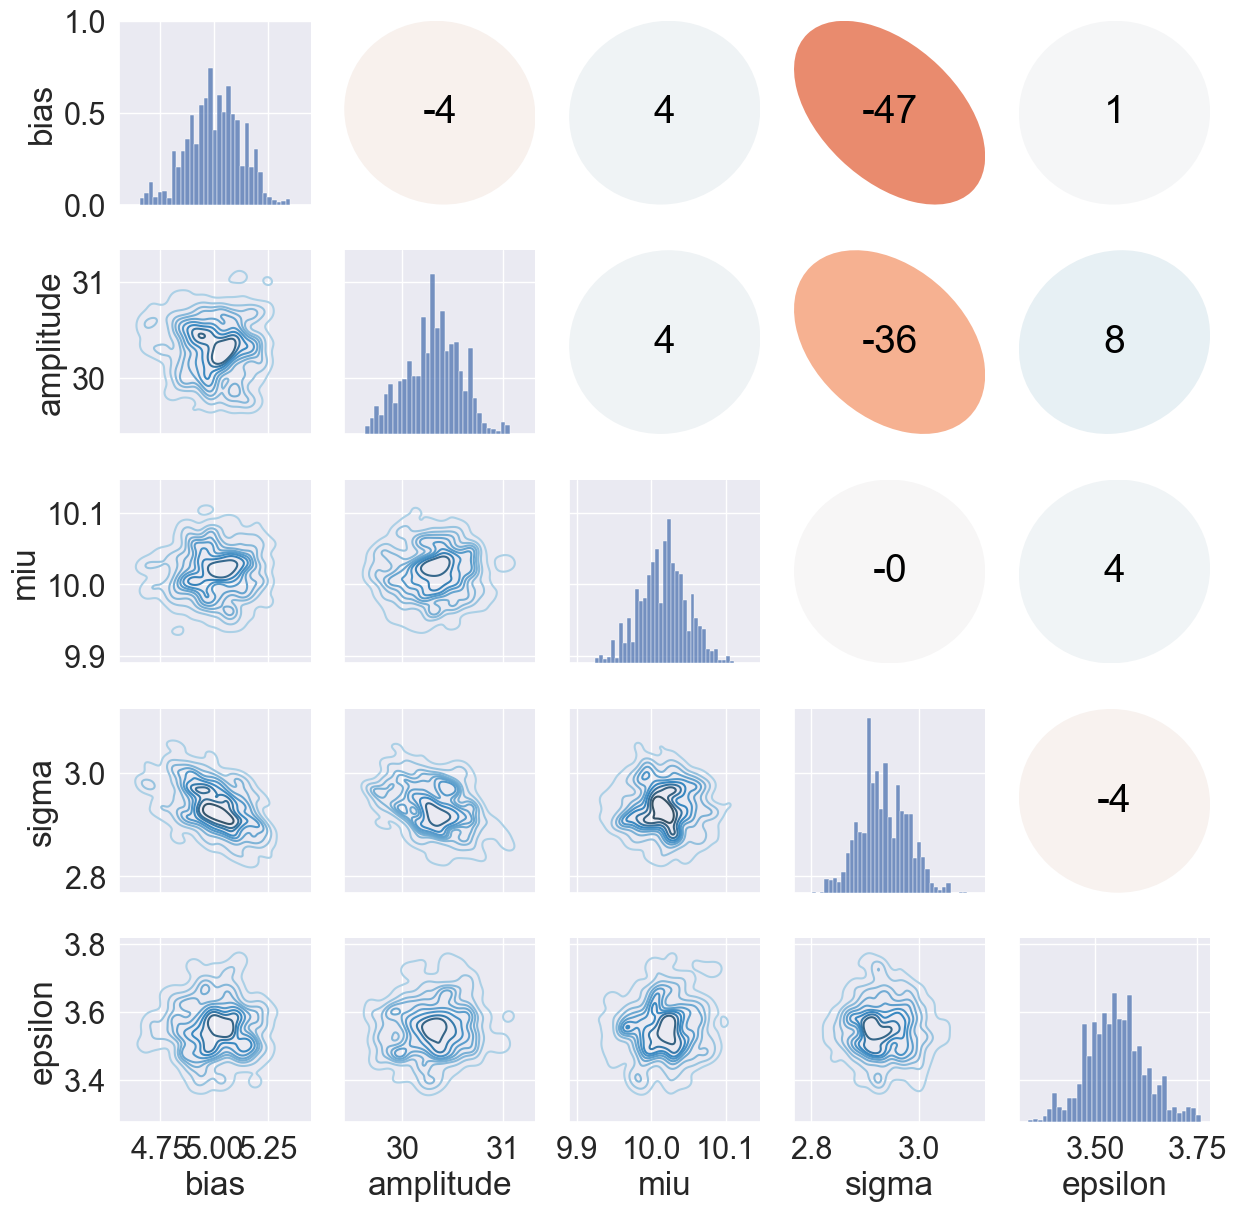

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats

d = df
def plot_upper(x, y, **kws):
    from matplotlib.patches import Ellipse
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('off')
    ellcolor = plt.cm.RdBu(0.5*(r+1))
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.add_artist(Ellipse(xy=[.5, .5], width=math.sqrt(1+r), height=math.sqrt(1-r), angle=45,
        facecolor=ellcolor, edgecolor='none', transform=ax.transAxes))
    ax.text(.5, .5, '{:.0f}'.format(r*100), color=txtcolor, fontsize=28,
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

sns.set(font_scale=2)
g = sns.PairGrid(d)
g.map_lower(sns.kdeplot, cmap='Blues_d')
g.map_diag(sns.histplot)
g.map_upper(plot_upper)